## Exercises

**Exercise:** Let's finish the exercise we started:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Here are the steps I recommend:

1. Starting with the same gamma prior we used in the previous problem, compute the likelihood of scoring a goal after 11 minutes for each possible value of `lam`.  Don't forget to convert all times into games rather than minutes.

2. Compute the posterior distribution of `lam` for Germany after the first goal.

3. Compute the likelihood of scoring another goal after 12 more minutes and do another update.  Plot the prior, posterior after one goal, and posterior after two goals.

4. Compute the posterior predictive distribution of goals Germany might score during the remaining time in the game, `90-23` minutes.  Note: you will have to think about how to generate predicted goals for a fraction of a game.

5. Compute the probability of scoring 5 or more goals during the remaining time.

In [2]:
import numpy as np
from scipy.stats import gamma, poisson
from empiricaldist import Pmf
from utils import set_pyplot_params, decorate, make_mixture
set_pyplot_params()


def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)
    
def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

def update_expo(pmf, data):
    """Update based on an observed interval
    
    pmf: prior PMF
    data: time between goals in minutes
    """
    t = data / 90
    lams = pmf.qs
    likelihood = expo_pdf(t, lams)
    pmf *= likelihood
    pmf.normalize()

def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

In [3]:
goals = np.arange(10)

# Create the prior
alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)
prior = Pmf(ps, qs)
prior.normalize()

# Solution

# Here are the updates for the first and second goals

germany = prior.copy()
update_expo(germany, 11)

germany2 = germany.copy()
update_expo(germany2, 12)

# Here are the mean values of `lam` after each update
germany.mean(), germany2.mean()

(2.1358882653086892, 2.703059034926364)

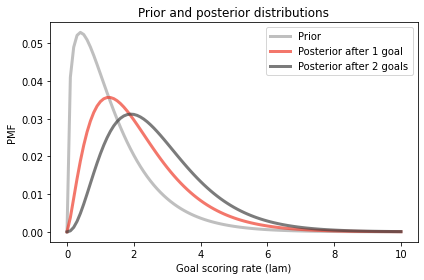

In [4]:
# Here's what the posterior distributions look like
prior.plot(color='C5', label='Prior')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C16', label='Posterior after 2 goals')

decorate_rate('Prior and posterior distributions')

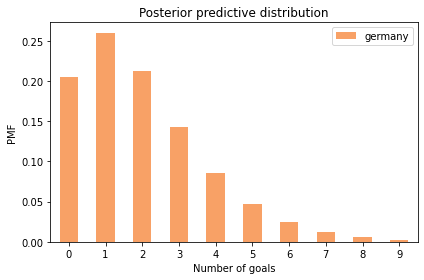

In [5]:
# Here's the predictive distribution for each possible value of `lam`
t = (90-23) / 90

pmf_seq = [make_poisson_pmf(lam*t, goals) 
           for lam in germany2.qs]

# And here's the mixture of predictive distributions,
# weighted by the probabilities in the posterior distribution.
pred_germany2 = make_mixture(germany2, pmf_seq)

# Here's what the predictive distribution looks like
pred_germany2.bar(color='C1', label='germany')
decorate_goals('Posterior predictive distribution')

In [6]:
pred_germany2.mean()

1.9994371012513807

In [7]:
# Here's the probability of scoring exactly 5 more goals
pred_germany2[5]

0.047109658706113416

In [8]:
# And the probability of 5 or more
pred_germany2.prob_le(5)

0.9542476574777679

**Exercise:** Returning to the first version of the World Cup Problem.  Suppose France and Croatia play a rematch.  What is the probability that France scores first?

Hint: Compute the posterior predictive distribution for the time until the first goal by making a mixture of exponential distributions.  You can use the following function to make a PMF that approximates an exponential distribution.

In [9]:
def make_expo_pmf(lam, high):
    """Make a PMF of an exponential distribution.
    
    lam: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [10]:
# Solution

# Here are the predictive distributions for the 
# time until the first goal

pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs]

In [11]:
# Solution

france = prior.copy()
update_poisson(france, 4)

croatia = prior.copy()
update_poisson(croatia, 2)

# And here are the mixtures based on the two posterior distributions

pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

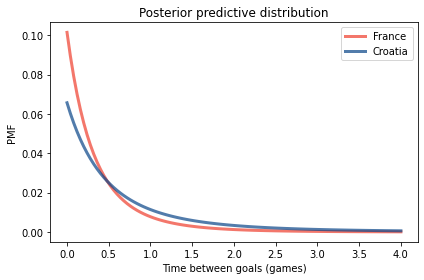

In [12]:
# Solution

# Here's what the posterior predictive distributions look like

pred_france.plot(label='France', color='C3')
pred_croatia.plot(label='Croatia', color='C0')

decorate_time('Posterior predictive distribution')

In [13]:
# Solution

# And here's the probability France scores first

Pmf.prob_lt(pred_france, pred_croatia)

0.5904596116867543

**Exercise:** In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston
Bruins played a best-of-seven championship series against the despised
Vancouver Canucks.  Boston lost the first two games 0-1 and 2-3, then
won the next two games 8-1 and 4-0.  At this point in the series, what
is the probability that Boston will win the next game, and what is
their probability of winning the championship?

To choose a prior distribution, I got some statistics from
http://www.nhl.com, specifically the average goals per game
for each team in the 2010-11 season.  The distribution is well modeled by a gamma distribution with mean 2.8.

In what ways do you think the outcome of these games might violate the assumptions of the Poisson model?  How would these violations affect your predictions?

In [14]:
# Solution

# When a team is winning or losing by an insurmountable margin,
# they might remove their best players from the game, which
# would affect their goal-scoring rate, violating the assumption
# that the goal scoring rate is constant.

# In this example, Boston won the third game 8-1, but scoring
# eight goals in a game might not reflect their true long-term
# goal-scoring rate.

# As a result, the analysis below might overestimate the chance
# that Boston wins.

# As it turned out, they did not.

In [15]:
# Solution

from scipy.stats import gamma

alpha = 2.8
qs = np.linspace(0, 15, 101)
ps = gamma.pdf(qs, alpha)
prior_hockey = Pmf(ps, qs)
prior_hockey.normalize()

6.666325137469514

2.7997400090376567

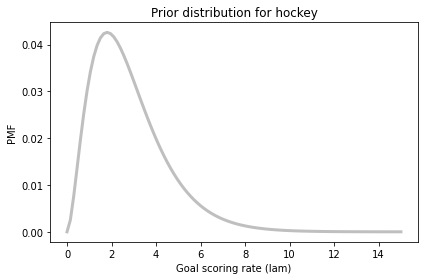

In [16]:
# Solution

prior_hockey.plot(color='C5')
decorate_rate('Prior distribution for hockey')
prior_hockey.mean()

In [17]:
# Solution

bruins = prior_hockey.copy()
for data in [0, 2, 8, 4]:
    update_poisson(bruins, data)
    
bruins.mean()

3.3599999999999985

In [18]:
# Solution

canucks = prior_hockey.copy()
for data in [1, 3, 1, 0]:
    update_poisson(canucks, data)
    
canucks.mean()

1.5599999606443666

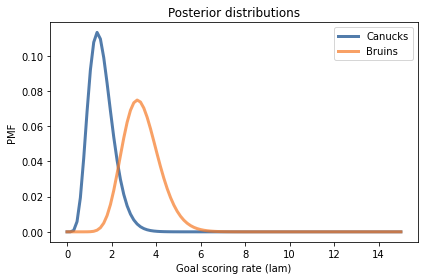

In [19]:
# Solution

canucks.plot(label='Canucks')
bruins.plot(label='Bruins')

decorate_rate('Posterior distributions')

In [20]:
# Solution

goals = np.arange(15)
pmf_seq = [make_poisson_pmf(lam, goals) for lam in bruins.qs]

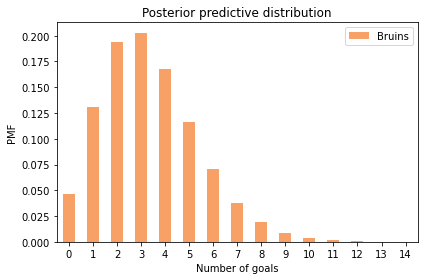

In [21]:
# Solution

pred_bruins = make_mixture(bruins, pmf_seq)

pred_bruins.bar(label='Bruins', color='C1')
decorate_goals('Posterior predictive distribution')

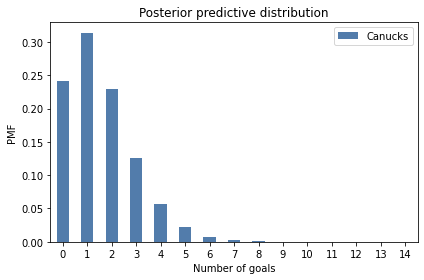

In [22]:
# Solution

pred_canucks = make_mixture(canucks, pmf_seq)

pred_canucks.bar(label='Canucks')
decorate_goals('Posterior predictive distribution')

In [23]:
# Solution

win = Pmf.prob_gt(pred_bruins, pred_canucks)
lose = Pmf.prob_lt(pred_bruins, pred_canucks)
tie = Pmf.prob_eq(pred_bruins, pred_canucks)

win, lose, tie

(0.7038631514645926, 0.16111690750716465, 0.1350199410282429)

In [24]:
# Solution

# Assuming the Bruins win half of the ties,
# their chance of winning the next game is...

p = win + tie/2
p

0.771373121978714

In [25]:
# Solution

# Their chance of winning the series is their
# chance of winning k=2 or k=3 of the remaining
# n=3 games.

from scipy.stats import binom

n = 3
a = binom.pmf([2,3], n, p)
a.sum()

0.8670900197850087